In [1]:
import cv2
import numpy as np
import tensorflow as tf
import sys
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\mrchan.000\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\mrchan.000\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\mrchan.000\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\u

In [2]:
# 数据集地址
data_dir = './famousface'

# 定义参数
batch_size = 50
OUTDIM = 64*64*3
n_Epoch = 6000

In [3]:
def get_data(dir,img_size):
    imgs = []
    path = os.path.join(dir,'*.png')
    # 获取path文件夹下的所有文件
    files = glob.glob(path)
    n_imgs = len(files)
    for index,file in enumerate(files):       
        img = cv2.imread(file)
        img = cv2.resize(img,(img_size,img_size))
        img = img / 255.0
        imgs.append(img)
        sys.stdout.write('{} / {}\r'.format(index,n_imgs))
    print('All Done')
    return np.array(imgs)     

In [4]:
X_real = get_data(data_dir,64).reshape(-1,OUTDIM)

All Done0000


In [5]:
# 判别器
# DC-GAN中使用带步长的卷积取代了池化，使用leakyRelu
def discriminator(samples,reuse=False):
    samples = tf.reshape(samples,[-1,64,64,3])
    with tf.variable_scope('discriminator',reuse=reuse):
        # 输入 64*64*3  卷积核大小 5*5 步长2 填充方式SAME 
        # 输出 32*32*64
        conv1 = tf.layers.conv2d(samples,64,5,2,padding='SAME',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 归一化
        conv1 = tf.nn.leaky_relu(conv1) 
        # 输入 32*32*64 卷积核大小 5*5 步长2 填充方式 SAME
        # 输出 16*16*128
        conv2 = tf.layers.conv2d(conv1,128,5,2,padding='SAME',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 归一化
        conv2 = tf.contrib.layers.layer_norm(conv2)
        conv2 = tf.nn.leaky_relu(conv2)

        # 输入 16*16*128 卷积核大小 5*5 步长2 填充方式SAME
        # 输出 8*8*256
        conv3 = tf.layers.conv2d(conv2,256,5,2,padding='SAME',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 归一化
        conv3 = tf.contrib.layers.layer_norm(conv3)
        conv3 = tf.nn.leaky_relu(conv3)
         # 输入 8*8*256 卷积核大小 5*5 步长2 填充方式SAME
        # 输出 4*4*512
        conv4 = tf.layers.conv2d(conv3,512,5,2,padding='SAME',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 归一化
        conv4 = tf.contrib.layers.layer_norm(conv4)
        conv4 = tf.nn.leaky_relu(conv4)

        # 降维
        flat = tf.layers.flatten(conv4)
        logits = tf.layers.dense(flat,1)
    return logits

In [6]:
# 生成器
def generotor(z_dim,reuse=False):
    z = tf.random_normal([batch_size,z_dim])
    with tf.variable_scope('generator',reuse=reuse):
        fc = tf.layers.dense(z,2*2*512)    
        fc = tf.reshape(fc,[-1,2,2,512])
        fc = tf.contrib.layers.layer_norm(fc)
        fc = tf.nn.relu(fc)
        # 反卷积 输入 2*2*512  输出 4*4*256
        conv1 = tf.layers.conv2d_transpose(fc,256,5,2,padding='SAME',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 归一化   
        conv1 = tf.contrib.layers.layer_norm(conv1)
        conv1 = tf.nn.relu(conv1)

        # 反卷积 输入4*4*256  输出 8*8*128
        conv2 = tf.layers.conv2d_transpose(conv1,128,5,2,padding='SAME',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 归一化   
        conv2 = tf.contrib.layers.layer_norm(conv2)
        conv2 = tf.nn.relu(conv2)
        
        # 反卷积  输入8*8*128 输出 16*16*64
        conv3 = tf.layers.conv2d_transpose(conv2,64,5,2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 归一化   
        conv3 = tf.contrib.layers.layer_norm(conv3)
        conv3 = tf.nn.relu(conv3)
        
        # 反卷积  输入16*16*64 输出 32*32*32
        conv3 = tf.layers.conv2d_transpose(conv3,32,5,2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 归一化   
        conv3 = tf.contrib.layers.layer_norm(conv3)
        conv3 = tf.nn.relu(conv3)
        
        logits = tf.layers.conv2d_transpose(conv3,3,5,2,padding='SAME')
        output = tf.tanh(logits)
        
        
        return tf.reshape(output,shape=[-1,OUTDIM])

In [7]:
# 损失函数
def model_loss(X_real,LAMBDA=10):
    G_out = generotor(16,reuse=False)
    
    real_score = discriminator(X_real,reuse=False)
    fake_score = discriminator(G_out,reuse=True)
    
    d_loss = tf.reduce_mean(fake_score) - tf.reduce_mean(real_score)
    g_loss = - tf.reduce_mean(fake_score)
    
    alpha = tf.random_uniform(
        [batch_size,1],
        minval=0,
        maxval=1
    )
    differences = G_out - X_real
    samples = X_real + alpha*differences
    grad_sam = tf.gradients(discriminator(samples,reuse=True),[samples])[0]
    grad_nom = tf.sqrt(tf.reduce_sum(grad_sam**2,axis=1))
    grad_pen = LAMBDA * tf.reduce_mean(tf.nn.relu(grad_nom - 1))
    d_loss += grad_pen
    return d_loss,g_loss,G_out

In [8]:
# 优化器
def model_opt(d_loss,g_loss,global_step):
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        var_list = tf.trainable_variables()
        d_var_list = [var for var in var_list if var.name.startswith('discriminator')]
        g_var_list = [var for var in var_list if var.name.startswith('generator')]
        
        d_opt = tf.train.AdamOptimizer(1e-4).minimize(d_loss,var_list=d_var_list,global_step=global_step)
        g_opt = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=g_var_list,global_step=global_step)
        
        return d_opt,g_opt  

In [9]:
# 获取训练数据
def next_batch(X_real,batch_size):
    total = len(X_real) // batch_size
    for i in range(total):
        yield X_real[i*batch_size:(i+1)*batch_size] 

In [10]:
# 显示函数
def show_img(imgs):   
    plt.imshow(imgs[0].reshape(64,64,3))     
    plt.show()

In [11]:
# 训练函数
def train(n_Epoch,learning_rate,X_real,batch_size,CRITIC_ITERS=5):
    save_dir = './famousface_models'
    
    with tf.Session() as sess:
        global_step = tf.train.get_or_create_global_step(sess.graph)
        input = tf.placeholder(tf.float32,shape=[None,OUTDIM])
        d_loss,g_loss,g_out = model_loss(input)
        d_opt,g_opt = model_opt(d_loss,g_loss,global_step)
        sess.run(tf.global_variables_initializer())
        
        # 检查点
        saver = tf.train.Saver()
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        checkpoint = tf.train.get_checkpoint_state(save_dir)   # 如果保存路径存在，则获取检查点的信息
        if checkpoint:    # 如果检查点存在
            saver.restore(sess,tf.train.latest_checkpoint(save_dir))    # 则重新加载上最近一次检查点
            print('Successfully loaded:',tf.train.latest_checkpoint(save_dir))
        else:
            print('cannot find old weight')
        
        for epochs in range(n_Epoch):
            input_real = next_batch(X_real,batch_size)
            for j in range((len(X_real) // batch_size) // CRITIC_ITERS):
                for k in range(CRITIC_ITERS):
                    _,d_l,step = sess.run([d_opt,d_loss,global_step],feed_dict={input:next(input_real)})                 
                _,g_l,out = sess.run([g_opt,g_loss,g_out])
                print('Epoch:{} / {} , batch:{} / {} , d_loss: {} , g_loss: {}'.format(epochs,n_Epoch,j,(len(X_real) // batch_size) // 5,d_l,g_l))         
            if epochs % 10 == 0:
                show_img(out)
                save_path = saver.save(sess, os.path.join(save_dir, 'best_model.ckpt'), global_step=step)
                print("Model saved in file: {}".format(save_path))
           

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./famousface_models\best_model.ckpt-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


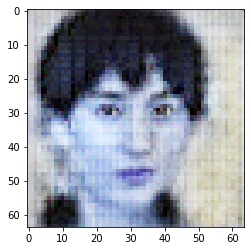

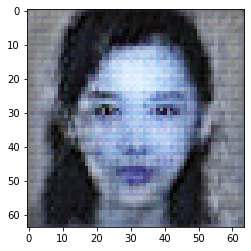

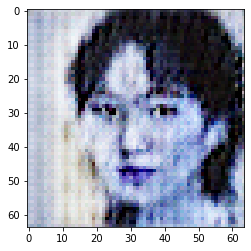

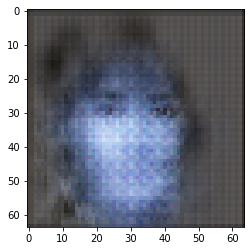

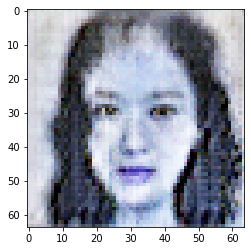

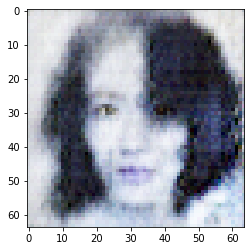

KeyboardInterrupt: 

In [12]:
tf.reset_default_graph()
with tf.Graph().as_default():
    train(n_Epoch,1e-4,X_real,batch_size)

In [ ]:
aa
